# Setup

In [1]:
!pip install --upgrade spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.2 MB 5.2 MB/s 
     |████████████████████████████████| 457 kB 63.1 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 660 kB 58.9 MB/s 
     |████████████████████████████████| 10.1 MB 51.2 MB/s 
     |████████████████████████████████| 181 kB 33.8 MB/s 
     |████████████████████████████████| 58 kB 5.2 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srs

In [2]:
import csv
import io
import os

import spacy 
from spacy.util import minibatch, compounding
from random import shuffle, seed
import numpy as np
import torch
from copy import deepcopy
from spacy.training import Example
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/Colab Notebooks/data/capstone/anno_8_tc.csv'

# Data Preparation

### Load in data

In [5]:
with open(file_path) as f:
    f.readline()
    reader = csv.reader(f)
    data = list(reader)

In [6]:
print(data[:5])

[['S1', '*'], ['Enter', 'O'], ['email', 'O'], ['address', 'O'], ['to', 'O']]


### Change to SpaCy format

In [7]:
# Change to SpaCy format
sents = []
sent = []
for word, tag in data:
  if tag == '*':
    if len(sent) > 0:
        sents.append(sent)
        sent = []
    else:
        continue
  else:
    sent.append((word, tag))

In [8]:
# sents

In [9]:
def get_entity(tag):
    return tag[2:]


def get_spacy_ner_data(data):
    result = []
    for sent in data:
        words = []
        entities = {'entities': []}
        i, start, end = 0, 0, 0

        for idx, (word, cur_tag) in enumerate(sent):
            if cur_tag[0] == 'B':
                tag = get_entity(cur_tag)
                start = i
                end = i + len(word)

            if cur_tag[0] == 'I':
                end += (1 + len(word))

            if cur_tag[0] == 'O':
                start = i
                end = i

            if end > start:
                if (idx == len(sent) - 1) or (not sent[idx+1][1][0] == 'I'):
                    entities['entities'].append([start, end, tag])

            i += (len(word) + 1)
            words.append(word)

        complete_sent = ' '.join(words)
        result.append((complete_sent, entities))
    return result

In [10]:
spacy_sents = get_spacy_ner_data(sents)

### Split train and test 

In [11]:
train_set, dev_set = train_test_split(spacy_sents, test_size=0.2, shuffle=True)

In [12]:
print(len(train_set), len(dev_set))

33 9


In [13]:
i = 0
for a, b in zip(sents, spacy_sents):
  print(i)
  print(a)
  print(b)
  print()
  i+=1

0
[('Enter', 'O'), ('email', 'O'), ('address', 'O'), ('to', 'O'), ('Email', 'B-location'), ('textbox', 'I-location'), ('admin1@mail.com', 'B-value')]
('Enter email address to Email textbox admin1@mail.com', {'entities': [[23, 36, 'location'], [37, 52, 'value']]})

1
[('Enter', 'O'), ('password', 'O'), ('to', 'O'), ('Password', 'B-location'), ('textbox', 'I-location'), ('Admin@123', 'B-value')]
('Enter password to Password textbox Admin@123', {'entities': [[18, 34, 'location'], [35, 44, 'value']]})

2
[('Click', 'O'), ('button', 'B-value'), ('Login', 'I-value')]
('Click button Login', {'entities': [[6, 18, 'value']]})

3
[('Wait', 'O'), ('title', 'B-value'), ('to', 'O'), ('be', 'O'), ('present', 'O'), ('for', 'O'), ('30', 'B-time'), ('seconds', 'I-time')]
('Wait title to be present for 30 seconds', {'entities': [[5, 10, 'value'], [29, 39, 'time']]})

4
[('Enter', 'O'), ('email', 'O'), ('address', 'O'), ('to', 'O'), ('Email', 'B-location'), ('textbox', 'I-location'), ('invalid@wrong', 'B

In [14]:
train_set

[('Enter email address to Email textbox invalid@wrong',
  {'entities': [[23, 36, 'location'], [37, 50, 'value']]}),
 ('Click button My Profile to go to Update my Profile page',
  {'entities': [[6, 23, 'value']]}),
 ('Wait email error message to appear for 3 seconds',
  {'entities': [[5, 24, 'value'], [39, 48, 'time']]}),
 ('On the Dashboard page , click the avatar on the top right corner to open menu',
  {'entities': [[34, 40, 'value']]}),
 ('Click submit button', {'entities': [[6, 19, 'value']]}),
 ('Enter new full name to full name text box',
  {'entities': [[23, 27, 'location'], [28, 41, 'location']]}),
 ('Enter', {'entities': []}),
 ('Wait title to appear for 10',
  {'entities': [[5, 10, 'value'], [25, 27, 'time']]}),
 ('Click button Change password to go to change password page',
  {'entities': [[6, 28, 'value']]}),
 ('Enter password to Password textbox invalidpassword',
  {'entities': [[18, 34, 'location'], [35, 50, 'value']]}),
 ('Click submit button', {'entities': [[6, 19, 'val

# Evaluation

In [15]:
def evaluate(sys_spacy_data, gold_spacy_data):
    precision, recall, fscore = 0, 0, 0

    # your code here
    tp = 0
    fp = 0
    fn = 0

    for sys_ex, gold_ex in zip(sys_spacy_data, gold_spacy_data):
        gold_annotations = set([tuple(e) for e in gold_ex[1]["entities"]])
        sys_annotations = set([tuple(e) for e in sys_ex[1]["entities"]])

        tp += len(sys_annotations.intersection(gold_annotations))
        fp += len(sys_annotations.difference(gold_annotations))
        fn += len(gold_annotations.difference(sys_annotations))

    if tp != 0:
        recall = (tp/(tp+fn)) * 100
        precision = (tp/(tp+fp)) * 100
        fscore = 2*recall*precision/(recall+precision)

    return precision, recall, fscore

# NER Model

### Initialize NER Model

In [16]:
def init_model(spacy_train_data, language):
    model = spacy.blank(language)

    seed(0)
    np.random.seed(0)
    spacy.util.fix_random_seed(0)
    torch.manual_seed(0)

    model.add_pipe("ner", last=True)
    ner = model.get_pipe("ner")

    for _, annotations in spacy_train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # Make sure we're only training the NER component of the pipeline
    pipe_exceptions = ["ner"]
    other_pipes = [pipe for pipe in model.pipe_names if pipe not in pipe_exceptions]

    # Start training so that we can use the model to annotate data
    model.disable_pipes(*other_pipes)
    optimizer = model.begin_training()
    return model, optimizer


untrained_model, _ = init_model(train_set, "en")

### Annotate

In [17]:
def annotate(spacy_data, model):
    result = []

    # your code here
    for sent, _ in spacy_data:
        doc = model(sent)
        entities = []
        for ent in doc.ents:
            entities.append((ent.start_char, ent.end_char, ent.label_))
        result.append((sent, {"entities": entities}))
    return result

### Train data

In [18]:
def train(spacy_train_data, spacy_dev_data, epochs,language):
    # Initialize model and get optimizer
    model, optimizer = init_model(spacy_train_data,language)

    # Make sure we don't permute the original training data.
    spacy_train_data = deepcopy(spacy_train_data)

    for itn in range(epochs):
        losses = {}

        # Create batches
        shuffle(spacy_train_data)
        batches = minibatch(spacy_train_data, size=compounding(4.0, 32.0, 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            example = []

            # Update the model with iterating each text
            for j in range(len(texts)):
                doc = model.make_doc(texts[j])
                example.append(Example.from_dict(doc, annotations[j]))

            model.update(example,
                         losses=losses,
                         drop=0.1)

        # Evaluate model
        print("Loss for epoch %u: %.4f" % (itn+1, losses["ner"]))
        spacy_dev_sys = annotate(spacy_dev_data, model)
        p, r, f = evaluate(spacy_dev_sys,spacy_dev_data)
        print("  PRECISION: %.2f%%, RECALL: %.2f%%, F-SCORE: %.2f%%" % (p,r,f))
    return model

In [19]:
ner_model = train(train_set, dev_set, 10, "en")
print()
print("Evaluating model on development set:")

dev_sys = annotate(dev_set, ner_model)

p, r, f = evaluate(dev_sys,dev_set)
print("  PRECISION: %.2f%%, RECALL: %.2f%%, F-SCORE: %.2f%%" % (p,r,f))

Loss for epoch 1: 192.2987
  PRECISION: 0.00%, RECALL: 0.00%, F-SCORE: 0.00%
Loss for epoch 2: 88.2957
  PRECISION: 0.00%, RECALL: 0.00%, F-SCORE: 0.00%
Loss for epoch 3: 67.3766
  PRECISION: 66.67%, RECALL: 26.67%, F-SCORE: 38.10%
Loss for epoch 4: 64.4912
  PRECISION: 87.50%, RECALL: 46.67%, F-SCORE: 60.87%
Loss for epoch 5: 90.5778
  PRECISION: 71.43%, RECALL: 66.67%, F-SCORE: 68.97%
Loss for epoch 6: 78.0169
  PRECISION: 75.00%, RECALL: 60.00%, F-SCORE: 66.67%
Loss for epoch 7: 45.5708
  PRECISION: 75.00%, RECALL: 60.00%, F-SCORE: 66.67%
Loss for epoch 8: 29.5326
  PRECISION: 75.00%, RECALL: 60.00%, F-SCORE: 66.67%
Loss for epoch 9: 21.5934
  PRECISION: 100.00%, RECALL: 93.33%, F-SCORE: 96.55%
Loss for epoch 10: 15.1252
  PRECISION: 100.00%, RECALL: 93.33%, F-SCORE: 96.55%

Evaluating model on development set:
  PRECISION: 100.00%, RECALL: 93.33%, F-SCORE: 96.55%


In [20]:
# dev_sys

In [21]:
# dev_set

### Check if dataset size affects F-score

In [22]:
data_size = [10, 15, 20, 25, 30, 35, 40]
fscores = []

for num in data_size:
    print(f'\n\nSize: {num}\n')
    train_set, dev_set = train_test_split(spacy_sents[:num], test_size=0.2, shuffle=True)

    ner_model = train(train_set, dev_set, 10, "en")
    print()
    print("Evaluating model on development set:")

    dev_sys = annotate(dev_set, ner_model)

    p, r, f = evaluate(dev_sys,dev_set)
    print("  PRECISION: %.2f%%, RECALL: %.2f%%, F-SCORE: %.2f%%" % (p,r,f))

    fscores.append(f)



Size: 10

Loss for epoch 1: 43.2972
  PRECISION: 0.00%, RECALL: 0.00%, F-SCORE: 0.00%
Loss for epoch 2: 41.4363
  PRECISION: 0.00%, RECALL: 0.00%, F-SCORE: 0.00%
Loss for epoch 3: 37.9194
  PRECISION: 0.00%, RECALL: 0.00%, F-SCORE: 0.00%
Loss for epoch 4: 29.9805
  PRECISION: 0.00%, RECALL: 0.00%, F-SCORE: 0.00%
Loss for epoch 5: 22.2543
  PRECISION: 0.00%, RECALL: 0.00%, F-SCORE: 0.00%
Loss for epoch 6: 18.6682
  PRECISION: 0.00%, RECALL: 0.00%, F-SCORE: 0.00%
Loss for epoch 7: 19.2726
  PRECISION: 0.00%, RECALL: 0.00%, F-SCORE: 0.00%
Loss for epoch 8: 17.6963
  PRECISION: 0.00%, RECALL: 0.00%, F-SCORE: 0.00%
Loss for epoch 9: 17.0996
  PRECISION: 0.00%, RECALL: 0.00%, F-SCORE: 0.00%
Loss for epoch 10: 17.0745
  PRECISION: 100.00%, RECALL: 20.00%, F-SCORE: 33.33%

Evaluating model on development set:
  PRECISION: 100.00%, RECALL: 20.00%, F-SCORE: 33.33%


Size: 15

Loss for epoch 1: 74.8396
  PRECISION: 0.00%, RECALL: 0.00%, F-SCORE: 0.00%
Loss for epoch 2: 67.6044
  PRECISION: 0.00

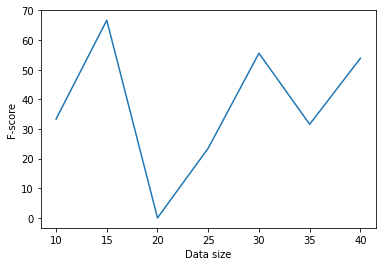

In [23]:
import matplotlib.pyplot as plt

plt.plot(data_size, fscores)
plt.xlabel('Data size')
plt.ylabel('F-score')
plt.show()